In [44]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter


# hits_true = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_2sigma.h5","hits")

# hits_true = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")
# hits      = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF2_780594_24.h5", "hits")

hits_true = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_smear.h5", "MC/hits")
hits      = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_0.1percent_smear.h5", "MC/hits")

display(hits)

,event_id,x,y,z,energy
0,500,5429.609863,1098.183838,6837.258301,0.000025
1,500,5420.311523,1146.210327,6838.670410,0.000025
2,500,5432.250977,1126.127930,6847.048340,0.000025
3,500,5426.397949,1085.181763,6847.395996,0.000025
4,500,5419.710938,1140.694580,6848.318359,0.000025
...,...,...,...,...,...
2105119,523,-1691.251099,-4112.806641,4788.525879,0.000025
2105120,523,-1692.635132,-4107.498535,4788.759766,0.000025
2105121,523,-1699.427856,-4108.126465,4789.019531,0.000025
2105122,523,-1692.637329,-4118.238281,4789.155273,0.000025


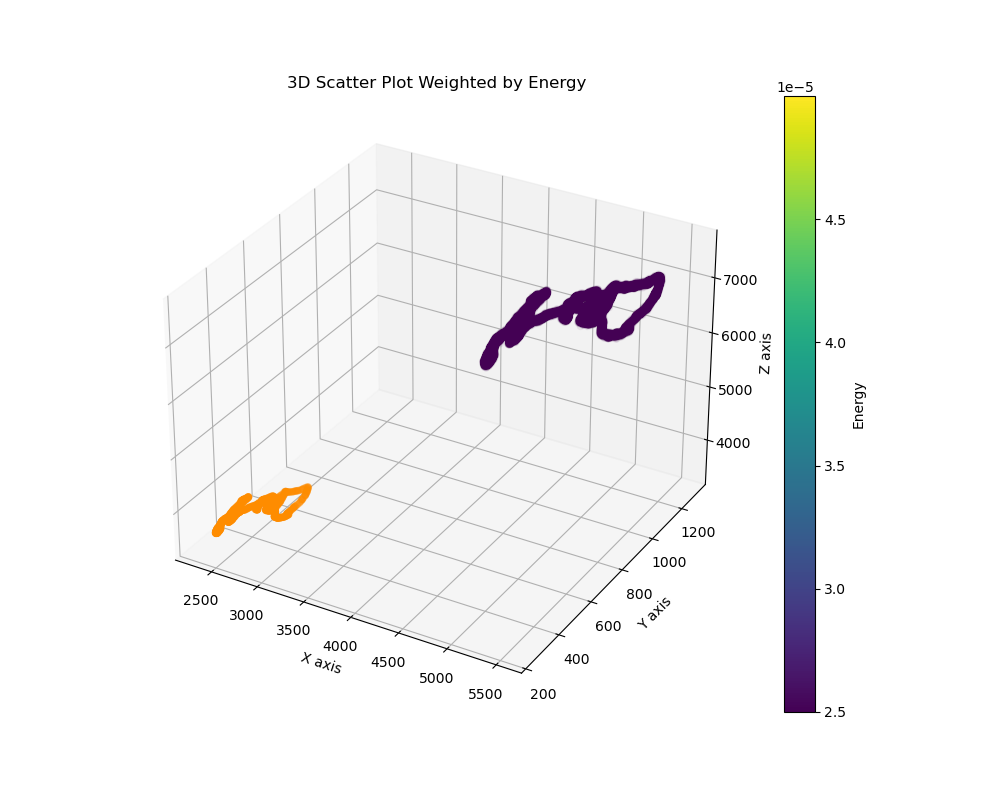

: 

In [45]:
%matplotlib widget 

eid=500

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


cut_data = data[data.energy > 0.000]

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(cut_data.energy.min(), cut_data.energy.max())
colors = cmap(norm(cut_data.energy))


# Plot the scatter plot
scatter = ax.scatter(cut_data.x, cut_data.y, cut_data.z, c=colors, marker='o', alpha=0.05)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
cbar = plt.colorbar(mappable)
cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [46]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

display(data)
print(len(dist_matrix))

20


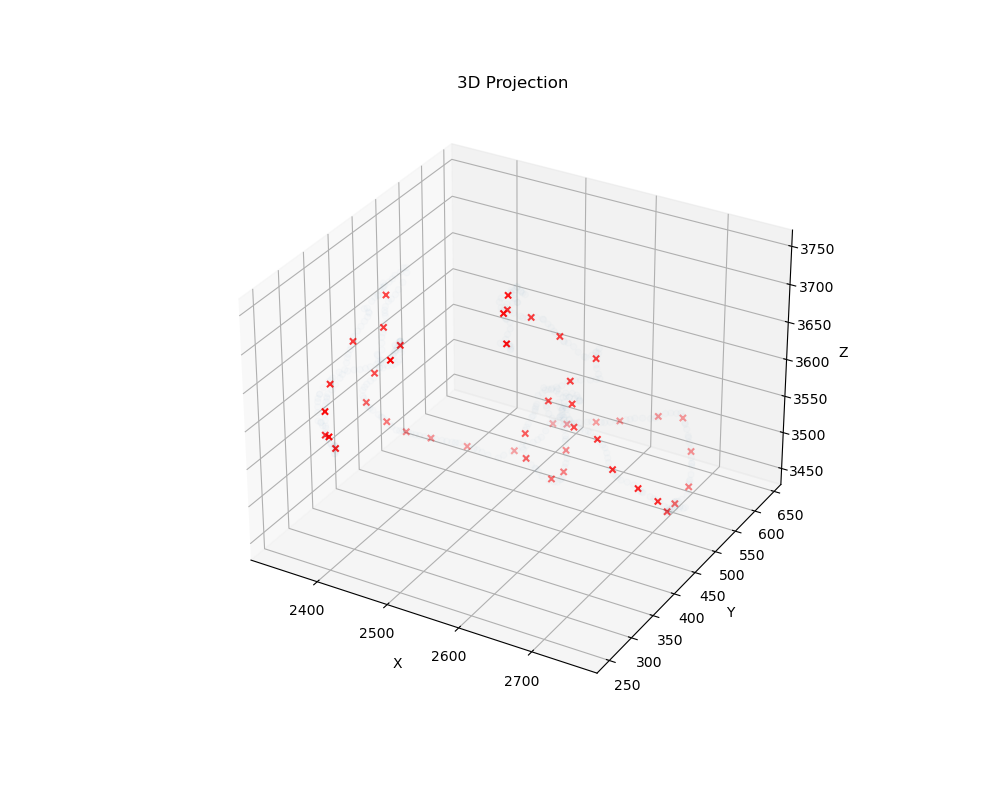

In [ ]:

# all_visited = []
radius  = 20 # workes well for 2 sigma c02 mix
# radius  = 0.5*np.sqrt(data.z.mean())
print(radius)


def GetMinima(index, all_visited_, input_data, temp_dist_matrix, R):


    distances_from_index = temp_dist_matrix[index] # distances for node to others
    sorted_indices = np.argsort(distances_from_index) # indexes sorted by smallest distance

    closest_nodes = sorted_indices[distances_from_index[sorted_indices] < R]
    
    closest_nodes = list(set(closest_nodes) - set(all_visited_))

    selected_rows = input_data.iloc[closest_nodes] # Df containing the nodes within distance

    # Compute the mean of x, y, and z columns
    mean_x = selected_rows['x'].median()
    mean_y = selected_rows['y'].median()
    mean_z = selected_rows['z'].median()
    energy_sum = selected_rows['energy'].sum()
    mean_point = np.array([mean_x, mean_y, mean_z, energy_sum])

    all_visited = all_visited_ + list(closest_nodes)

    return mean_point, all_visited


def Cluster(input_data, R):

    node_centers = []
    all_visited = []
    indexes = input_data.index.values
    indexes_set = set(indexes)

    temp_dist_matrix = distance_matrix(input_data[['x', 'y', 'z']], input_data[['x', 'y', 'z']])

    for i in range(1000):

        all_visited_set = set(all_visited)

        # Convert arrays to sets and perform the difference
        filtered_indexes = list(indexes_set - all_visited_set)

        if not filtered_indexes:
            break

        random_index = np.random.choice(filtered_indexes)
        median, all_visited = GetMinima(random_index, all_visited, input_data, temp_dist_matrix, R)

        node_centers.append(median)

    return pd.DataFrame(node_centers, columns=['x', 'y', 'z', 'energy'])



node_centers_df = Cluster(data, 10)
node_centers_df = Cluster(node_centers_df, 20)
node_centers_df = Cluster(node_centers_df, 30)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 75)


# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')

ax.scatter(node_centers_df['x'], node_centers_df['y'], node_centers_df['z'], marker='x',c="r")



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



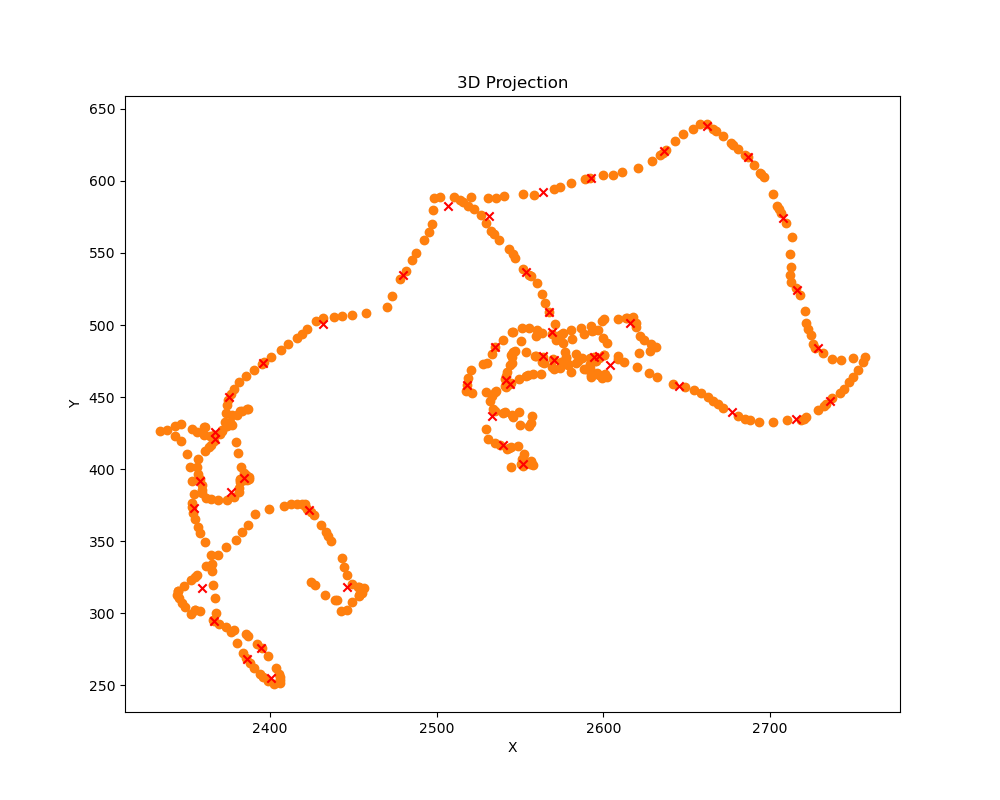

In [ ]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o',alpha=0.1)
plt.scatter(data_true['x'], data_true['y'], marker='o')
plt.scatter(node_centers_df['x'], node_centers_df['y'], marker='x',c="r")

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()


In [ ]:
# Create the bins ---- 
xmin=-3000
xmax=3000
xbw=50

ymin=-3000
ymax=3000
ybw=50

zmin=0
zmax=6000
zbw=50

# bw = 10 works well for co2 mix with 2 sigma diffusion

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


databin = node_centers_df.copy()
databin["event_id"] = eid

 # Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)

#Loop over the rows in the dataframe and merge the energies. Also change the bin center to use the mean x,y,z position
x_mean_arr = []
y_mean_arr = []
z_mean_arr = []
energy_mean_arr = []
x_mean_arr_temp = np.array([])
y_mean_arr_temp = np.array([])
z_mean_arr_temp = np.array([])
summed_energy = 0
event_id = 0

counter = 0

# test_df = test_df.reset_index()
databin = databin.sort_values(by=['x_smear', 'y_smear', 'z_smear'])
databin["energy"] = 1


for index, row in databin.iterrows():

    # First row
    if (counter == 0):
        temp_x = row["x_smear"]
        temp_y = row["y_smear"]
        temp_z = row["z_smear"]
        summed_energy +=row["energy"]
        event_id = row["event_id"]
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        counter+=1
        continue

    # Final row
    if index == databin.index[-1]:
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]

        if (summed_energy != 0): 
            x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
            y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
            z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
            energy_mean_arr.append(summed_energy)


    # Same bin
    if (row["x_smear"] == temp_x and row["y_smear"] == temp_y and row["z_smear"] == temp_z):
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]

    # Aggregate and store for next 
    else:
        if (summed_energy != 0): 
            x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
            y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
            z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
            energy_mean_arr.append(summed_energy)
        
        temp_x = row["x_smear"]
        temp_y = row["y_smear"]
        temp_z = row["z_smear"]
        summed_energy = 0
        x_mean_arr_temp = np.array([])
        y_mean_arr_temp = np.array([])
        z_mean_arr_temp = np.array([])
        
        
        x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
        y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
        z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
        summed_energy +=row["energy"]
        

    counter+=1

events = np.ones_like(energy_mean_arr)*event_id

# Make the dataframe again
databin = pd.DataFrame({  "event_id" : events, "x" : x_mean_arr,  "y" : y_mean_arr,  "z" : z_mean_arr,  "energy" : energy_mean_arr  }) 

display(databin)

,event_id,x,y,z,energy
0,500.0,2380.250671,285.414207,3575.529541,2.0
1,500.0,2386.458496,268.198349,3626.152832,1.0
2,500.0,2359.173706,317.530678,3629.332520,1.0
3,500.0,2358.261353,391.557686,3566.621094,1.0
4,500.0,2376.562012,384.329590,3614.559570,1.0
5,500.0,2369.542053,383.356361,3664.669678,2.0
6,500.0,2367.125732,421.003723,3527.508789,1.0
7,500.0,2366.722656,426.051376,3695.030518,1.0
8,500.0,2395.989990,473.940125,3484.971924,1.0
9,500.0,2375.653564,450.077271,3500.677246,1.0


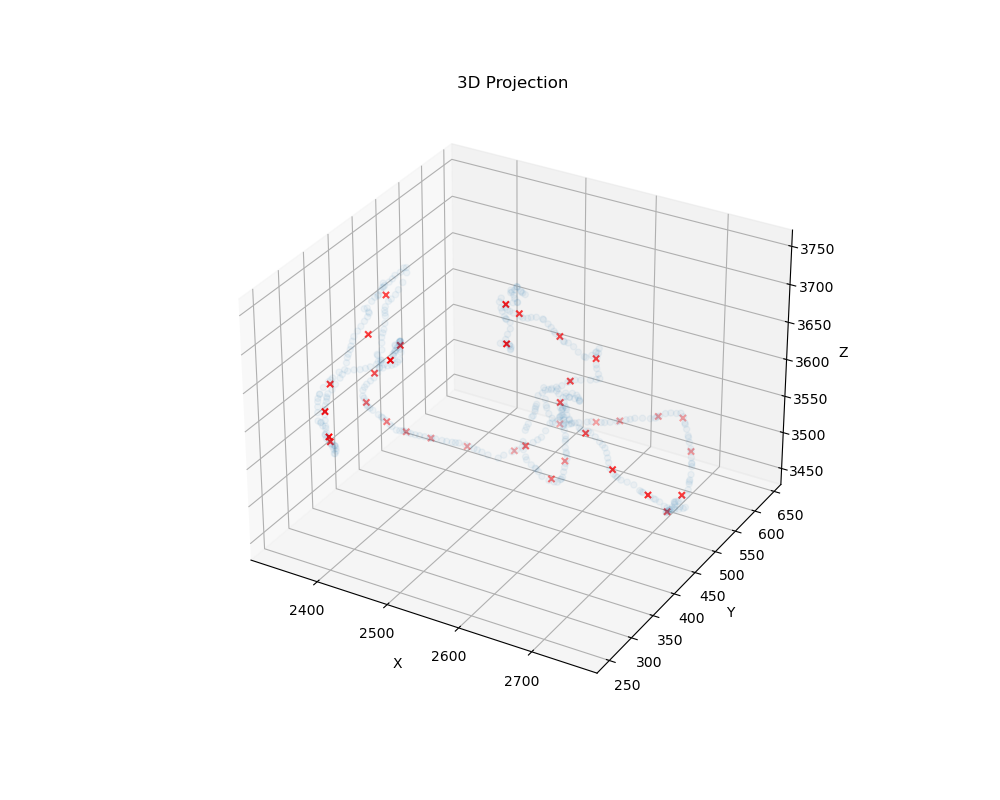

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")

ax.scatter(databin['x'], databin['y'], databin['z'], marker='x',c="r")




ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

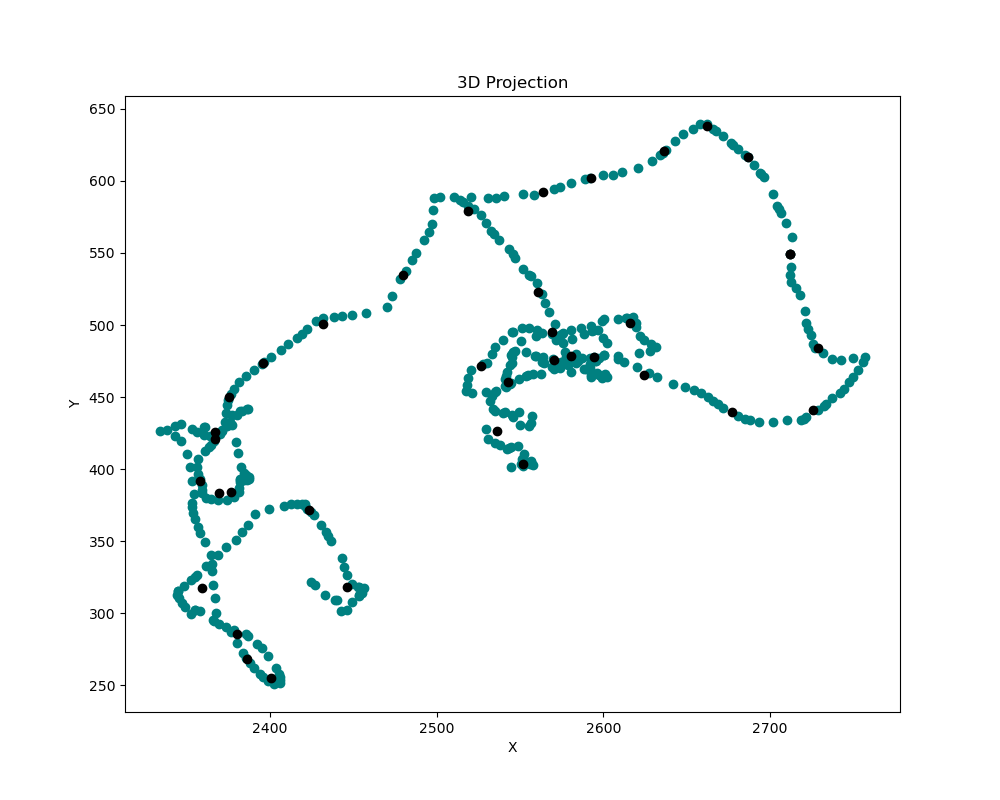

In [ ]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o',alpha=0.1)
plt.scatter(data_true['x'], data_true['y'], marker='o',color="Teal")
plt.scatter(databin['x'], databin['y'], marker='o',c="k")

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()